In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
import os
from astropy.table import Table

In [2]:
from read_sfh import get_scales
small_file_fname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/small_sfh_catalog_1.002310.txt"
scale_factor_array = get_scales(small_file_fname)
redshift_array = (1./scale_factor_array) - 1
cosmic_age_array = np.load(os.path.join(os.path.dirname(small_file_fname), 'prelim_sfh_reduction', 'times.npy'))

In [3]:
from collate_full_catalog import collate_catalog
z_string = 'z0'


history_colnames = ('halo_id', 'halo_upid', 'halo_mpeak', 'stellar_mass', 'sfr', 'sfr_mp', 'sm_mp')
halocat_propnames = ('halo_id', 'first_acc_scale', 'mpeak_scale', 'acc_rate_1tdyn')

cat = collate_catalog(z_string, history_colnames=history_colnames, 
                      halocat_propnames=halocat_propnames, verbose=False)

... Assembling history data
... Assembling halo catalog data
New colnames to add from halo catalog = ['first_acc_scale', 'mpeak_scale', 'acc_rate_1tdyn']


In [4]:
first_acc_index = np.interp(cat['first_acc_scale'], scale_factor_array, np.arange(len(scale_factor_array)))
cat['first_acc_index'] = np.round(first_acc_index).astype(int)

mpeak_scale_index = np.interp(cat['mpeak_scale'], scale_factor_array, np.arange(len(scale_factor_array)))
cat['halo_mpeak_index'] = np.round(mpeak_scale_index).astype(int)

cat['gal_mstar_peak_index'] = np.argmax(cat['sm_mp'], axis=1)

In [5]:
from pre_infall_average import pre_infall_average, post_infall_average

In [6]:
sats = cat[cat['gal_type'] == 'satellite']
cens = cat[cat['gal_type'] == 'central']
backsplash = cat[cat['gal_type'] == 'backsplash']
orphans = cat[cat['gal_type'] == 'orphan']

In [134]:
quenched_sats = sats[sats['sfr']/sats['stellar_mass'] < 10**-11]
active_sats = sats[sats['sfr']/sats['stellar_mass'] >= 10**-11]

## Calculate average SM histories before and after infall

In [18]:
# Mpeak-based mask
# logmpeak_low, logmpeak_high = 11.5, 11.75
# mask_sats = (sats['halo_mpeak'] > 10**logmpeak_low) & (sats['halo_mpeak'] < 10**logmpeak_high)
# mask_cens = (cens['halo_mpeak'] > 10**logmpeak_low) & (cens['halo_mpeak'] < 10**logmpeak_high)

# Stellar mass-based mask
logsm_low, logsm_high = 10.0, 10.1
mask_sats = (sats['stellar_mass'] > 10**logsm_low) & (sats['stellar_mass'] < 10**logsm_high)
mask_cens = (cens['stellar_mass'] > 10**logsm_low) & (cens['stellar_mass'] < 10**logsm_high)

In [19]:
avg_pre_infall_smh_sats = pre_infall_average(sats[mask_sats]['sm_mp'], sats[mask_sats]['first_acc_index'])
avg_post_infall_smh_sats = post_infall_average(sats[mask_sats]['sm_mp'], sats[mask_sats]['first_acc_index'])

avg_smh_cens = np.mean(cens[mask_cens]['sm_mp'], axis=0)

In [ ]:
avg_sfr_mp_sats = pre_infall_average(sats[mask_sats]['sfr_mp'], sats[mask_sats]['first_acc_index'])
avg_sfr_mp_sats_no_exclusion = np.mean(sats[mask_sats]['sfr_mp'], axis=0)
avg_sfr_mp_cens = np.mean(cens[mask_cens]['sfr_mp'], axis=0)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel('time  [Gyr]', fontsize=15)
ylabel = ax.set_ylabel(r'$\langle{\rm SFR}\rangle$', fontsize=16)
title = ax.set_title(r'$M_{\ast}(z=0) \approx 10^{10}M_{\odot}$', fontsize=16, y=1.02) # y param fixes an overhanging title

last_idx = -1
ax.plot(redshift_array[:last_idx], avg_sfr_mp_cens[:last_idx], 
         color='blue', label='centrals', linewidth=1.5)
ax.plot(redshift_array[:last_idx], avg_sfr_mp_sats[:last_idx], 
         color='red', label='pre-infall satellites', linewidth=1.5)
ax.plot(redshift_array[:last_idx], avg_sfr_mp_sats_no_exclusion[:last_idx], 
         '--', color='red', label='satellites', linewidth=1.5)

ax.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='gray')
plt.xlim(xmin=8, xmax=0.15)
plt.xscale('log')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.tick_params(axis='x', length=4, width=1, which='major')
ax.tick_params(axis='x', length=2, width=1, which='minor')
ax.tick_params(axis='y', length=4, width=1, which='major')
ax.tick_params(axis='y', length=2, width=1, which='minor')

plt.legend(frameon=False, loc='upper left', fontsize=13)

# fig.savefig('FIGS/pre_infall_evolution_cens_vs_sats.pdf',
#             bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [10]:
print(sats.keys())

['halo_id', 'halo_upid', 'sfr_mp', 'sfr', 'halo_mpeak', 'sm_mp', 'stellar_mass', 'first_acc_scale', 'mpeak_scale', 'acc_rate_1tdyn', 'gal_type', 'first_acc_index', 'halo_mpeak_index', 'gal_mstar_peak_index', 'sm_at_infall']


# Calculate $\langle M_{\ast}^{\rm infall}\rangle$ vs. $M_{\ast}(z=0)$

In [9]:
sats['sm_at_infall'] = sats['sm_mp'][np.arange(len(sats)), sats['first_acc_index']]

In [8]:
from halotools.mock_observables import mean_y_vs_x

In [34]:
mpeak_bins = np.logspace(11, 14.5, 20)
mpeak_z0, mean_infall_sm, mean_infall_sm_err = mean_y_vs_x(sats['halo_mpeak'], 
                                                       sats['sm_at_infall'], 
                                                       bins=mpeak_bins)
__, mean_sm, __ = mean_y_vs_x(sats['halo_mpeak'], sats['stellar_mass'], 
                                                       bins=mpeak_bins)

t_since_infall = cosmic_age_array[-1] - cosmic_age_array[sats['first_acc_index']]
__, mean_t_since_infall, __ = mean_y_vs_x(sats['halo_mpeak'], t_since_infall, 
                                                       bins=mpeak_bins)



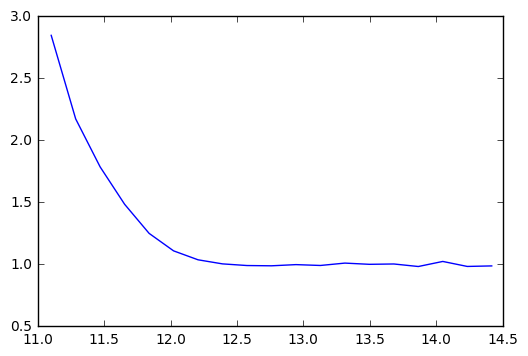

In [35]:
plt.plot(np.log10(mpeak_z0), mean_sm/mean_infall_sm)

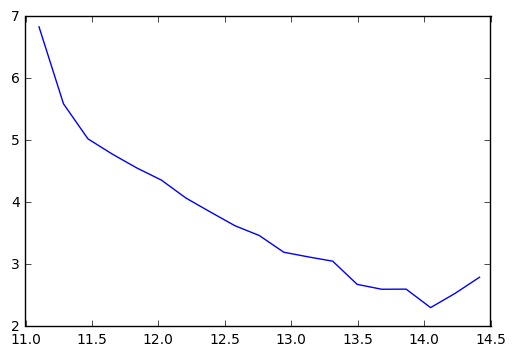

In [40]:
plt.plot(np.log10(mpeak_z0), mean_t_since_infall)

In [175]:
nbins = 20
mpeak_bins = np.logspace(11, 13.5, nbins)
stellar_mass_bins = np.logspace(9, 11.25, nbins)
stellar_mass_mids = 10**(0.5*(np.log10(stellar_mass_bins[:-1]) + np.log10(stellar_mass_bins[1:])))

mean_sm_at_z0_sats = np.zeros(len(mpeak_bins)-1)
mean_sm_at_infall_sats = np.zeros(len(mpeak_bins)-1)
mean_sm_at_infall_quenched_sats = np.zeros(len(mpeak_bins)-1)
mean_sm_at_infall_active_sats = np.zeros(len(mpeak_bins)-1)
mean_sm_at_infall_cens = np.zeros(len(mpeak_bins)-1)
mean_sm_at_infall_sats_variance = np.zeros(len(mpeak_bins)-1)

for i, low, high in zip(range(nbins-1), stellar_mass_bins[:-1], stellar_mass_bins[1:]):
    
    satmask = (sats['stellar_mass'] >= low) & (sats['stellar_mass'] < high)
    sat_sample = sats[satmask]
    num_sats_ibin = len(sats['stellar_mass'][satmask])
    mean_sm_at_infall_sats[i] = np.mean(sat_sample['sm_mp'][np.arange(num_sats_ibin), sat_sample['first_acc_index']])
    mean_sm_at_infall_sats_variance[i] = np.std(sat_sample['sm_mp'][np.arange(num_sats_ibin), sat_sample['first_acc_index']])
#     mean_sm_at_z0_sats[i] = np.mean(sat_sample['stellar_mass'])

    quenched_satmask = (quenched_sats['stellar_mass'] >= low) & (quenched_sats['stellar_mass'] < high)
    quenched_sat_sample = quenched_sats[quenched_satmask]
    num_quenched_sats_ibin = len(quenched_sat_sample)
    assert num_quenched_sats_ibin > 0, "\a nonzero quenched_sat_sample required!"
    mean_sm_at_infall_quenched_sats[i] = np.mean(quenched_sat_sample['sm_mp'][np.arange(num_quenched_sats_ibin), quenched_sat_sample['first_acc_index']])

    active_satmask = (active_sats['stellar_mass'] >= low) & (active_sats['stellar_mass'] < high)
    active_sat_sample = active_sats[active_satmask]
    num_active_sats_ibin = len(active_sat_sample)
    assert num_active_sats_ibin > 0, "\a nonzero active_sat_sample required!"
    mean_sm_at_infall_active_sats[i] = np.mean(active_sat_sample['sm_mp'][np.arange(num_active_sats_ibin), active_sat_sample['first_acc_index']])

    cenmask = (cens['stellar_mass'] >= low) & (cens['stellar_mass'] < high)
    num_cens_ibin = len(cens['stellar_mass'][cenmask])
    idx_random_cen_select = np.random.randint(0, num_cens_ibin-1, num_sats_ibin)
    cen_sample = cens[cenmask][idx_random_cen_select]
    mean_sm_at_infall_cens[i] = np.mean(cen_sample['sm_mp'][np.arange(num_sats_ibin), sat_sample['first_acc_index']])

Number of points = 18


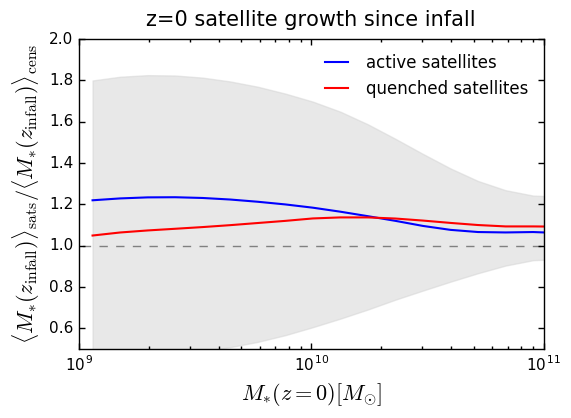

In [183]:
from scipy.signal import savgol_filter, medfilt

fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\ast}(z=0) [M_{\odot}]$', fontsize=16)
ylabel = ax.set_ylabel(r'$\langle M_{\ast}(z_{\rm infall})\rangle_{\rm sats} / \langle M_{\ast}(z_{\rm infall})\rangle_{\rm cens}$', fontsize=16)
title = ax.set_title('z=0 satellite growth since infall', fontsize=15, y=1.02) # y param fixes an overhanging title

sm_max = 2e11
idx_last = np.max(np.where(mean_sm_at_z0_sats <= sm_max)[0])
idx_last = -1
print("Number of points = {0}".format(len(mean_sm_at_z0_sats[:idx_last])))

_x = stellar_mass_mids[:idx_last]

# All satellites
_y = mean_sm_at_infall_sats[:idx_last]/mean_sm_at_infall_cens[:idx_last]
_y = savgol_filter(_y, 13, 5)
_y = medfilt(_y, 3)
_dy = savgol_filter(mean_sm_at_infall_sats_variance[:idx_last]/mean_sm_at_infall_cens[:idx_last], 13, 4)
# ax.plot(_x, _y, color='k', linewidth=1.5)
ax.fill_between(_x, _y-_dy, _y+_dy, color='lightgray', alpha=0.5)

# active satellites
_y3 = mean_sm_at_infall_active_sats[:idx_last]/mean_sm_at_infall_cens[:idx_last]
_y3 = medfilt(_y3, 3)
_y3 = savgol_filter(_y3, 13, 5)
ax.plot(_x, _y3, color='blue', linewidth=1.5, label='active satellites')

# quenched satellites
_y2 = mean_sm_at_infall_quenched_sats[:idx_last]/mean_sm_at_infall_cens[:idx_last]
_y2 = savgol_filter(_y2, 13, 5)
_y2 = medfilt(_y2, 3)
ax.plot(_x, _y2, color='red', linewidth=1.5, label='quenched satellites')

ax.plot(np.logspace(8, 12, 100), np.ones(100), '--', color='gray')
plt.xscale('log')
plt.xlim(xmin = 1e9, xmax=1e11)
plt.ylim(ymin = 0.5, ymax = 2)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax.tick_params(axis='x', length=4, width=1, which='major')
ax.tick_params(axis='x', length=2, width=1, which='minor')
ax.tick_params(axis='y', length=4, width=1, which='major')
ax.tick_params(axis='y', length=2, width=1, which='minor')

plt.legend(frameon=False, loc='upper right', fontsize=12)

fig.savefig('FIGS/mstar_growth_since_infall.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [221]:
low, high = 10**10, 10**10.1
sats_sm_z0_mask = (sats['stellar_mass'] >= low) & (sats['stellar_mass'] < high)
sats_in_situ_sfr_history = np.mean(sats['sfr_mp'][sats_sm_z0_mask], axis=0)

cens_sm_z0_mask = (cens['stellar_mass'] >= low) & (cens['stellar_mass'] < high)
cens_in_situ_sfr_history = np.mean(cens['sfr_mp'][cens_sm_z0_mask], axis=0)

In [222]:
infall_times = cosmic_age_array[sats[sats_sm_z0_mask]['first_acc_index']]
median_infall_time = cosmic_age_array[-1] - np.median(infall_times)

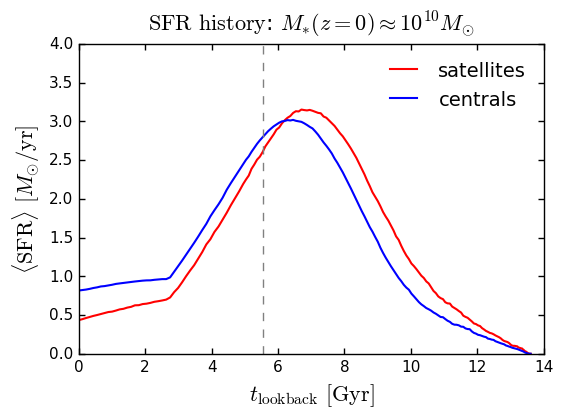

In [223]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$t_{\rm lookback}$ $[{\rm Gyr}]$', fontsize=16)
ylabel = ax.set_ylabel(r'$\langle{\rm SFR}\rangle$ $[M_{\odot}/{\rm yr}]$', fontsize=16)
title = ax.set_title(r'${\rm SFR}$ ${\rm history}$: $M_{\ast}(z=0) \approx 10^{10}M_{\odot}$', fontsize=16, y=1.02) # y param fixes an overhanging title

ax.plot(cosmic_age_array[-1]-cosmic_age_array, sats_in_situ_sfr_history, 
         linewidth=1.5, color='red', label='satellites')
ax.plot(cosmic_age_array[-1]-cosmic_age_array, cens_in_situ_sfr_history,
         linewidth=1.5, color='blue', label='centrals')

ax.plot(np.zeros(100) + median_infall_time, np.arange(100), '--', color='gray')

plt.xlim(xmin = 0, xmax=14)
plt.ylim(ymin = 0, ymax = 4)

plt.xticks(fontsize=11); plt.yticks(fontsize=11)
ax.tick_params(axis='x', length=4, width=1, which='major')
ax.tick_params(axis='x', length=2, width=1, which='minor')
ax.tick_params(axis='y', length=4, width=1, which='major')
ax.tick_params(axis='y', length=2, width=1, which='minor')

plt.legend(frameon=False, loc='best', fontsize=14)
fig.savefig('FIGS/sfr_history_cens_sats_comparison.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [224]:
low, high = 10**10, 10**10.1
sats_sm_z0_mask = (sats['stellar_mass'] >= low) & (sats['stellar_mass'] < high)
sats_sm_history = np.mean(sats['sm_mp'][sats_sm_z0_mask], axis=0)

cens_sm_z0_mask = (cens['stellar_mass'] >= low) & (cens['stellar_mass'] < high)
cens_sm_history = np.mean(cens['sm_mp'][cens_sm_z0_mask], axis=0)

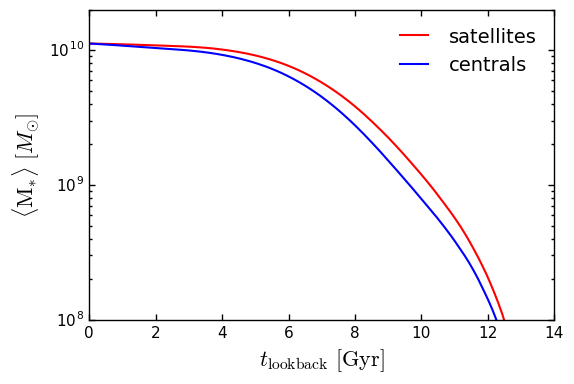

In [231]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$t_{\rm lookback}$ $[{\rm Gyr}]$', fontsize=16)
ylabel = ax.set_ylabel(r'$\langle{\rm M_{\ast}}\rangle$ $[M_{\odot}]$', fontsize=16)
# title = ax.set_title(r'${\rm M_{\ast}}$ ${\rm history}$', fontsize=16, y=1.02) # y param fixes an overhanging title

ax.plot(cosmic_age_array[-1]-cosmic_age_array, sats_sm_history, 
         linewidth=1.5, color='red', label='satellites')
ax.plot(cosmic_age_array[-1]-cosmic_age_array, cens_sm_history,
         linewidth=1.5, color='blue', label='centrals')

ax.plot(np.zeros(100) + median_infall_time, np.arange(100), '--', color='gray')

plt.xlim(xmin = 0, xmax=14)
plt.ylim(ymin = 1e8, ymax = 2e10)
plt.yscale('log')
plt.xticks(fontsize=11); plt.yticks(fontsize=11)
ax.tick_params(axis='x', length=4, width=1, which='major')
ax.tick_params(axis='x', length=2, width=1, which='minor')
ax.tick_params(axis='y', length=4, width=1, which='major')
ax.tick_params(axis='y', length=2, width=1, which='minor')

plt.legend(frameon=False, loc='best', fontsize=14)
fig.savefig('FIGS/sm_history_cens_sats_comparison.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')